In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
#%matplotlib widget
#%config InlineBackend.figure_format = 'svg'

In [3]:
import copy
import datetime
import json
import os
import scipy.spatial
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import celeri
celeri = reload(celeri)

In [4]:
RUN_NAME = datetime.datetime.now().strftime("%y%m%d%H%M%S") + os.sep
with open('./data/western_north_america/command.json', 'r') as f:
    command = json.load(f)
station = pd.read_csv(command["station_file_name"])
segment = pd.read_csv(command["segment_file_name"])
block = pd.read_csv(command["block_file_name"])

In [5]:
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command)

In [6]:
np_segments = np.zeros((len(segment), 2, 2))
np_segments[:, 0, 0] = segment.lon1.to_numpy()
np_segments[:, 1, 0] = segment.lon2.to_numpy()
np_segments[:, 0, 1] = segment.lat1.to_numpy()
np_segments[:, 1, 1] = segment.lat2.to_numpy()

In [7]:
# De-duplicate the vertices and build an ptr_edge array
all_vertices = np_segments.reshape((-1, 2))
tree = scipy.spatial.KDTree(all_vertices, leafsize=1000)
duplicates = tree.query_ball_point(all_vertices, 1e-8)

edge_idx_to_vertex_idx = []
vertex_idx_to_edge_idx = []
dedup_vertices = []
original_to_new = dict()
for i in range(np_segments.shape[0]):
    v1_idx = duplicates[2 * i][0]
    v2_idx = duplicates[2 * i + 1][0]
    
    if v1_idx == 2 * i:
        original_to_new[2 * i] = len(dedup_vertices)
        dedup_vertices.append(np_segments[i][0])
        vertex_idx_to_edge_idx.append([])
        
    if v2_idx == 2 * i + 1:
        original_to_new[2 * i + 1] = len(dedup_vertices)
        dedup_vertices.append(np_segments[i][1])
        vertex_idx_to_edge_idx.append([])
        
    edge_idx = len(edge_idx_to_vertex_idx)
    edge_idx_to_vertex_idx.append((original_to_new[v1_idx], original_to_new[v2_idx]))
    vertex_idx_to_edge_idx[original_to_new[v1_idx]].append(edge_idx)
    vertex_idx_to_edge_idx[original_to_new[v2_idx]].append(edge_idx)

n_edges = len(edge_idx_to_vertex_idx)
n_vertices = len(dedup_vertices)

edge_idx_to_vertex_idx = np.array(edge_idx_to_vertex_idx, dtype=int)
#reverse_edge_idx_to_vertex_idx = np.fliplr(edge_idx_to_vertex_idx)
vertex_idx_to_edge_idx = np.array(vertex_idx_to_edge_idx, dtype=object)
dedup_vertices = np.array(dedup_vertices)

In [8]:
# Check that the vertices are unique up to 1e-8 now.
new_tree = scipy.spatial.KDTree(dedup_vertices)
assert(np.all([v[0] == i for i,v in enumerate(new_tree.query_ball_point(dedup_vertices, 1e-8))]))

In [9]:
def angle(v1, v2, v3):
    """
    Compute the angle between the vector (v2, v3) and (v1, v2)
    The angle is constrained to lie in [-np.pi, np.pi]
    No turn will result in an angle of 0. 
    A left turn will produce a positive angle.
    A right turn will produce a negative angle.
    """
    A1 = np.arctan2(v3[1] - v2[1], v3[0] - v2[0])
    A2 = np.arctan2(v2[1] - v1[1], v2[0] - v1[0])
    
    angle = A1 - A2
    if angle < -np.pi:
        angle += 2 * np.pi
    elif angle > np.pi:
        angle -= 2 * np.pi
    return angle

In [10]:
%%time
def identify_rightward_half_edge(v1_idx, v2_idx, edge_idx):
    v1, v2 = dedup_vertices[[v1_idx, v2_idx]]
    
    # All the edges connected to v2 except for the edge (v1,v2)
    possible_edges = [e_i for e_i in vertex_idx_to_edge_idx[v2_idx] if e_i != edge_idx]

    # Identify the angle for each potential edge. 
    angles = []
    edge_direction = []
    for e in possible_edges:
        possible_vs = edge_idx_to_vertex_idx[e]
        direction = 1 if possible_vs[0] == v2_idx else 0
        v3 = dedup_vertices[possible_vs[direction]]
        angles.append(angle(v1, v2, v3))
        edge_direction.append(direction)
    
    # The right turn will have the smallest angle.
    right_idx = np.argmin(angles)
    
    # Return a half edge index instead of an edge index. 
    return 2 * possible_edges[right_idx] + edge_direction[right_idx]

"""
Introducing... half edges! 
Now, the edge from v1_idx --> v2_idx will be different from the edge from v2_idx --> v1_idx.
half edge idx 2*edge_idx+0 refers to the edge (v2_idx, v1_idx0)
half edge idx 2*edge_idx+1 refers to the edge (v1_idx, v2_idx0)
Thus every edge corresponds to two oppositely ordered half edges.

Then, for each half edge, identify the next half edge that is "to the right"
in the direction that the half edge points. That is, following the vector
from the first vertex to the second vertex along that half edge, which half 
edge from the connected edges is the one that turns most sharply to the right.

From this right_half_edge data structure, it will be straightforward to follow
the next rightwards half edge around a polygon and identify each individual 
polygon. 
"""

right_half_edge = np.empty(n_edges * 2, dtype=int)
for edge_idx in range(n_edges):
    v1_idx, v2_idx = edge_idx_to_vertex_idx[edge_idx]
    right_half_edge[2 * edge_idx + 0] = identify_rightward_half_edge(v2_idx, v1_idx, edge_idx)
    right_half_edge[2 * edge_idx + 1] = identify_rightward_half_edge(v1_idx, v2_idx, edge_idx)

CPU times: user 13.4 ms, sys: 255 µs, total: 13.7 ms
Wall time: 11.6 ms


In [11]:
%%time
def get_half_edge_vertices(half_edge_idx):
    """
    A helper function to get the vertex indices corresponding to a half edge.
    """
    v1_idx, v2_idx = edge_idx_to_vertex_idx[half_edge_idx // 2]
    if half_edge_idx % 2 == 0:
        v2_idx, v1_idx = v1_idx, v2_idx
    return v1_idx, v2_idx

# Which polygon lies to the right of the half edge.
right_polygon = np.full(n_edges * 2, -1, dtype=int)

# Lists specifying which half edges lie in each polygon.
polygons = []
    
for half_edge_idx in range(2 * n_edges):
    # If this half edge is already in a polygon, skip it.
    if right_polygon[half_edge_idx] >= 0:
        continue
    
    # Follow a new polygon around its loop by indexing the right_half_edge array.
    polygon_idx = len(polygons)
    polygons.append([half_edge_idx])
    next_idx = right_half_edge[half_edge_idx]
    while next_idx != half_edge_idx:
        # Step 1) Check that we don't have errors!
        if next_idx in polygons[-1]:
            raise Exception("Geometry problem: unexpected loop found in polygon traversal.")
        if right_polygon[next_idx] != -1:
            raise Exception("Geometry problem: write a better error message here")
        
        # Step 2) Record the half edge
        polygons[-1].append(next_idx)
        
        # Step 3) 
        next_idx = right_half_edge[next_idx]
        
    right_polygon[polygons[-1]] = polygon_idx

CPU times: user 466 µs, sys: 6 µs, total: 472 µs
Wall time: 476 µs


In [12]:
# Convert the polygons array which lists half edges into a 
# polygon_vertices array which lists the vertices for each polygon.
polygon_vertices = []
for p in polygons:
    polygon_vertices.append([])
    for half_edge_idx in p:
        v1_idx, v2_idx = get_half_edge_vertices(half_edge_idx)
        polygon_vertices[-1].append(v2_idx)

In [13]:
plt.close("all")

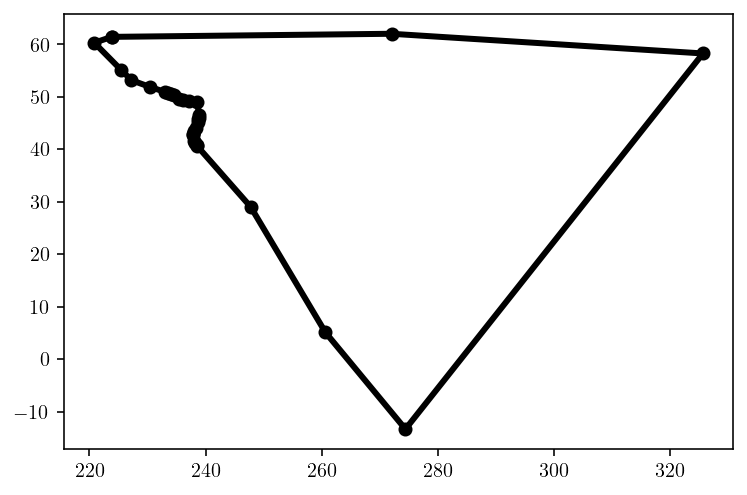

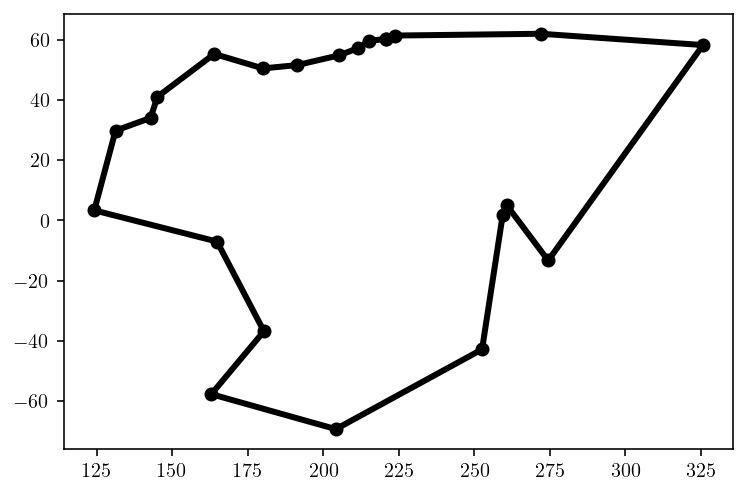

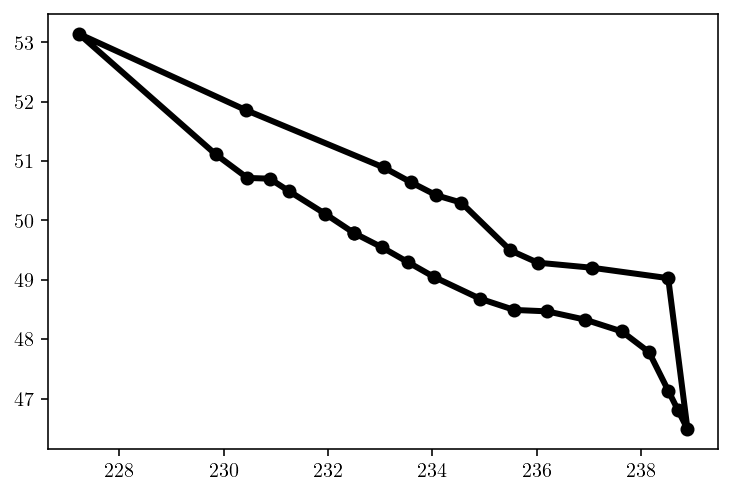

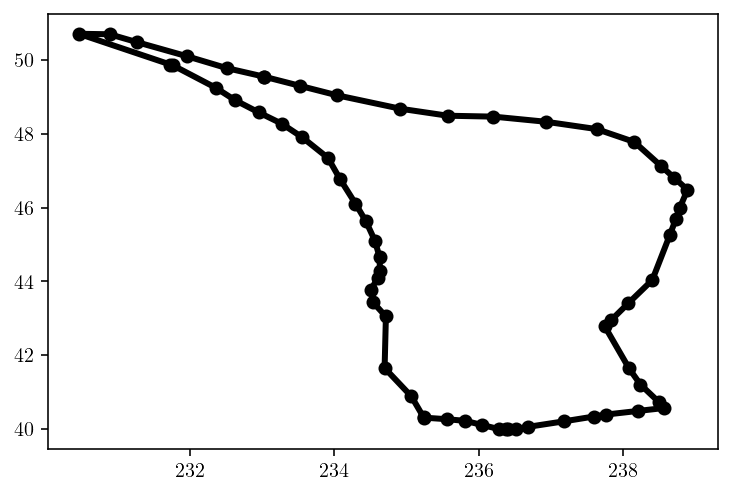

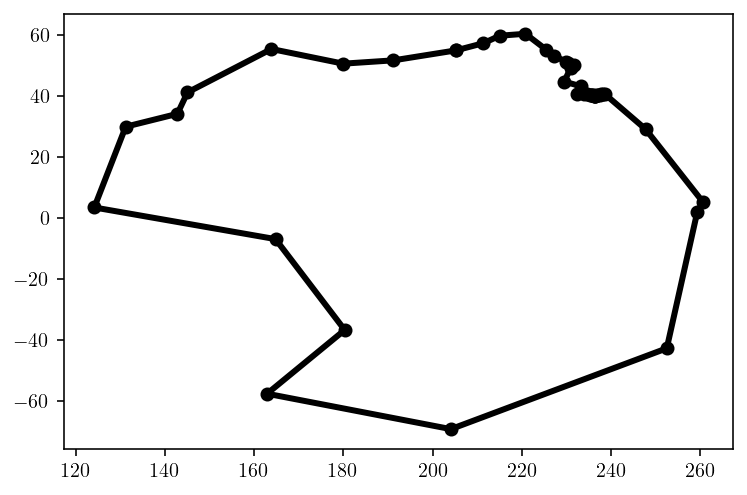

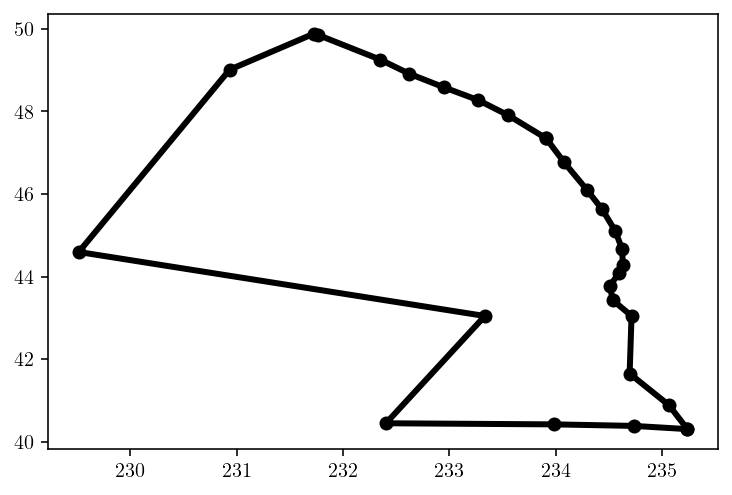

In [14]:
for p in polygon_vertices:
    plt.figure()
    vs = np.concatenate([dedup_vertices[p], dedup_vertices[p[0]][None,:]])
    plt.plot(vs[:,0], vs[:,1], 'k-o')
    plt.show()

In [15]:
unprocessed_value = -1 # use negative number here so that it never accidentally collides with a real block label
segment['east_labels'] = unprocessed_value
segment['west_labels'] = unprocessed_value

In [16]:
# Identify east and west labels based on the blocks assigned to each half edge.
for current_block_label, p in enumerate(polygons):
    for half_edge_idx in p:
        v1_idx, v2_idx = get_half_edge_vertices(half_edge_idx)
        v1 = dedup_vertices[v1_idx]
        v2 = dedup_vertices[v2_idx]
        edge_vector = v2 - v1
        edge_right_normal = [edge_vector[1], -edge_vector[0]]
        
        # East side because right-hand normal points east
        # And west side if not!
        # Remember, because we're dealing with half edges, 
        # we need to do integer division by two to get the normal edge index
        if edge_right_normal[0] > 0:
            segment['east_labels'].iloc[half_edge_idx // 2] = current_block_label
        else:
            segment['west_labels'].iloc[half_edge_idx // 2] = current_block_label

/home/tbent/.miniconda3/envs/celeri/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
# Check for unprocessed indices
np.union1d(np.where(segment['east_labels'] == unprocessed_value),
                             np.where(segment['west_labels'] == unprocessed_value))

array([], dtype=int64)

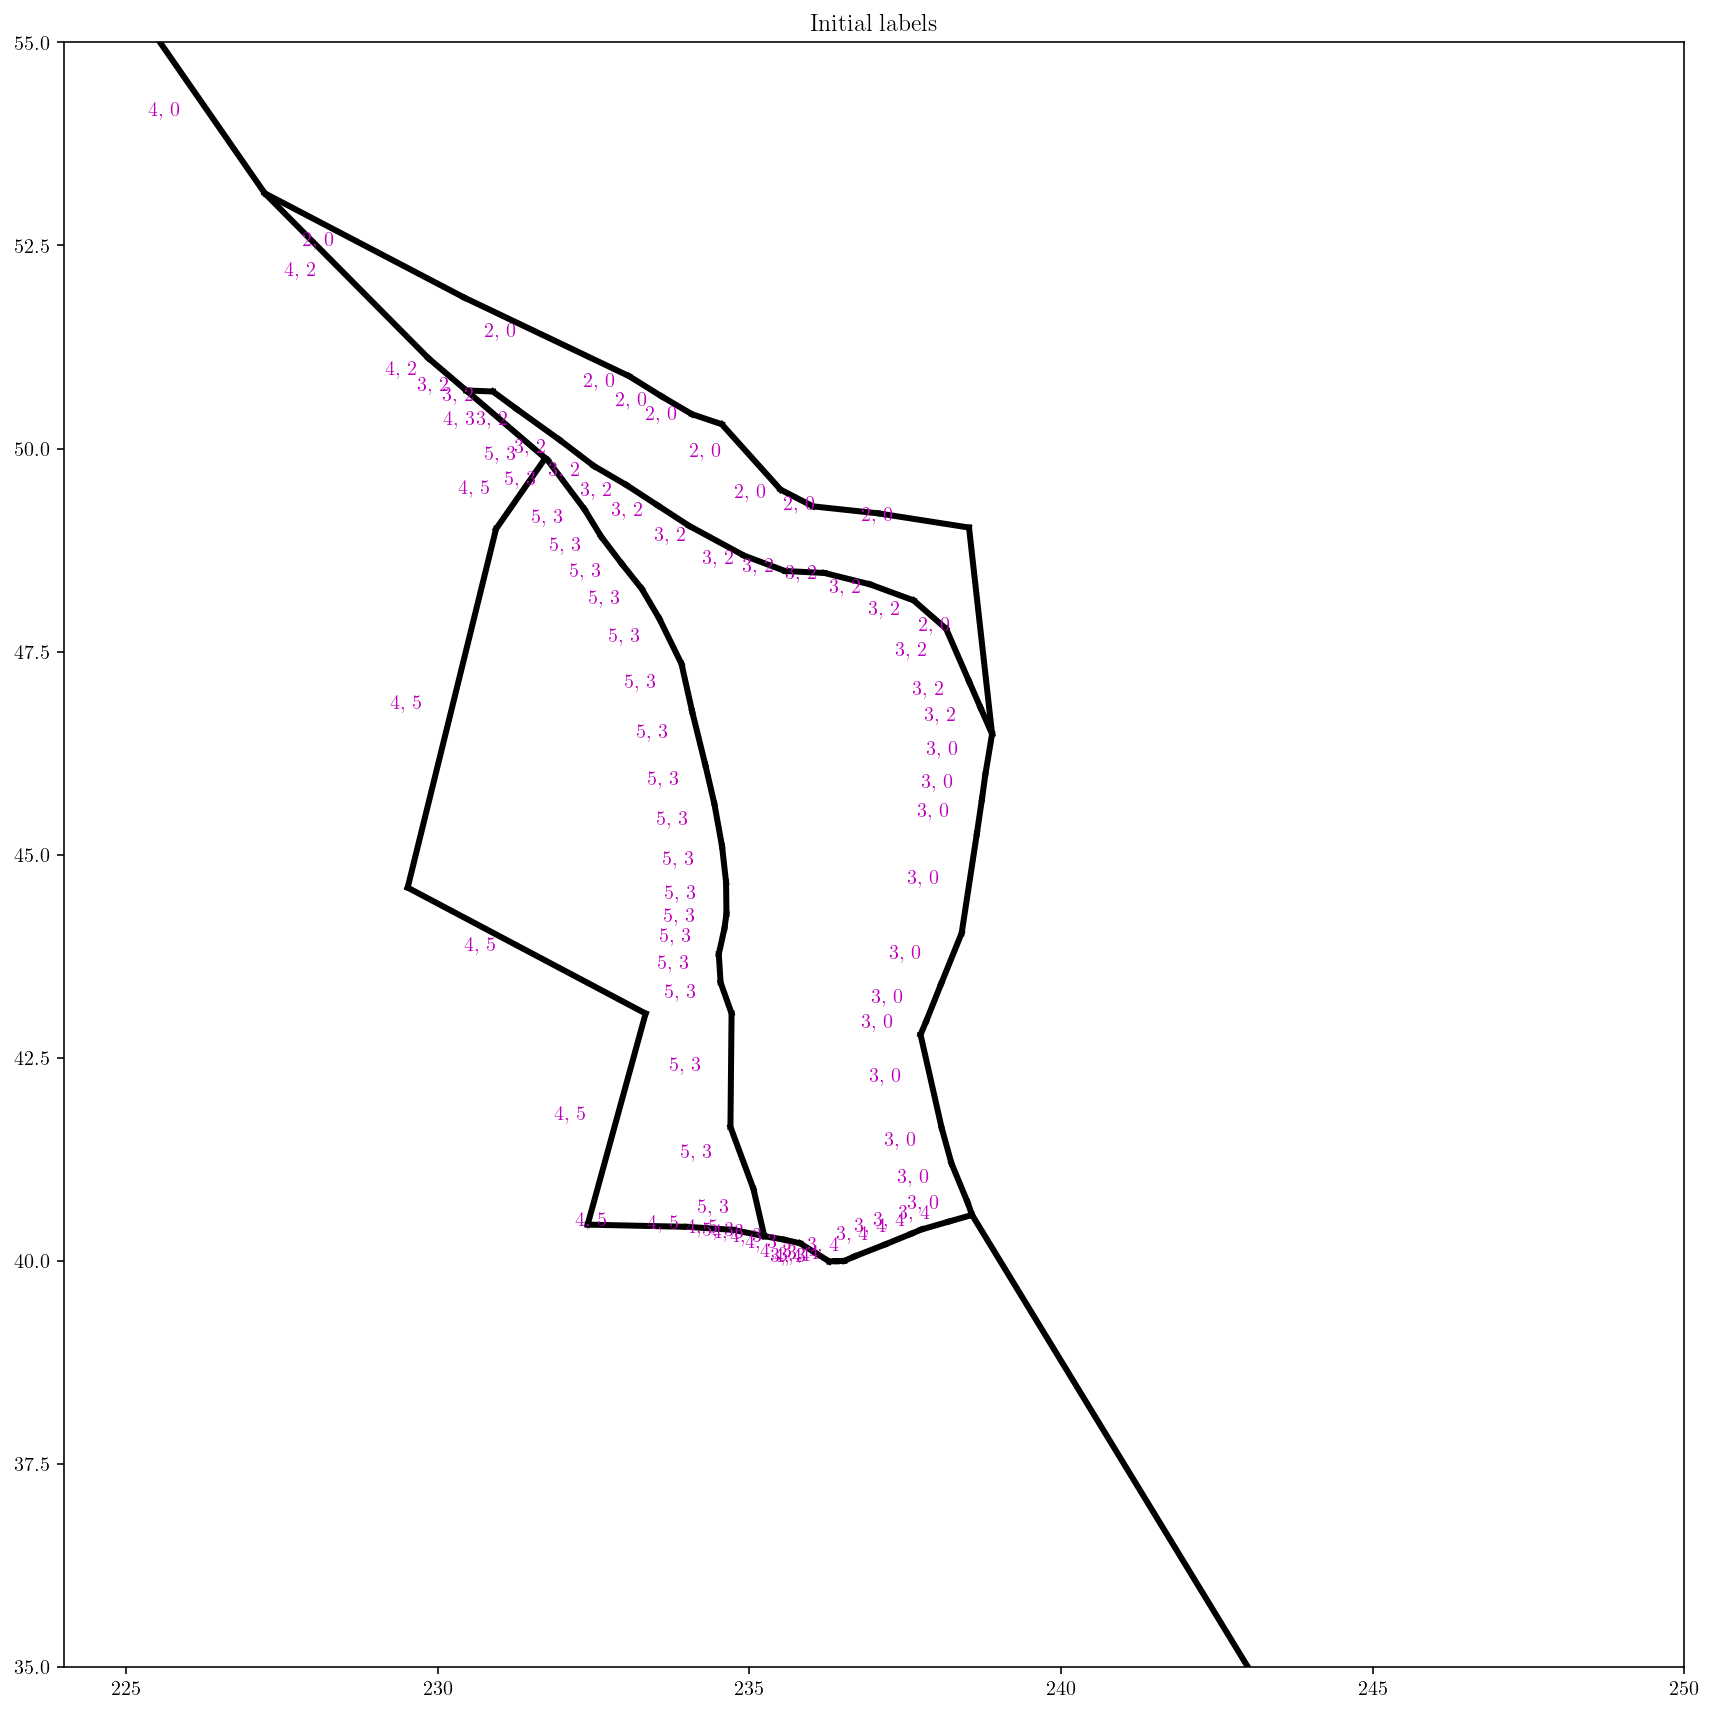

In [24]:
plt.figure(figsize=(12,12))
plt.title("Initial labels")
for i in range(len(segment)):
    plt.plot([segment.lon1.values[i], segment.lon2.values[i]],
             [segment.lat1.values[i], segment.lat2.values[i]], "-k")
    if 224 < segment.mid_lon_plate_carree.values[i] < 250 and 35 < segment.mid_lat_plate_carree.values[i] < 55:
        plt.text(segment.mid_lon_plate_carree.values[i] - 1.0,
                 segment.mid_lat_plate_carree.values[i],
                str(segment['west_labels'][i]) + ",  " + str(segment['east_labels'][i]),
                 fontsize=10, color='m')
plt.xlim([224,250])
plt.ylim([35,55])
plt.tight_layout()
plt.show()